In [11]:
import numpy as np
import pandas as pd
import os
import dotenv
import matplotlib.pyplot as plt
from models.model1 import create_model1
from models.model2 import create_model2
from models.model3 import create_model3
from models.model4 import create_model4
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [8]:
dotenv.load_dotenv()
home_path = os.getenv("HOME_PATH")

In [9]:
resources_path = "/EnigmaGridSolver/Sudoku.NeuralNet/Resources/"
data = pd.read_csv(home_path + resources_path + "sudoku.csv")
data.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   quizzes    1000000 non-null  object
 1   solutions  1000000 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


### Number of blanks in sudokus

In [12]:
number_blanks = []
for i in range(len(data)):
    number_blanks.append(data["quizzes"][i].count("0"))
number_blanks[:10]

[46, 47, 47, 48, 49, 48, 47, 46, 46, 48]

In [13]:
data["number_blanks"] = number_blanks
data.tail()

,quizzes,solutions,number_blanks
999995,3000280000290000300054001077402030980086070031...,3175289464291768356854391277462135989586472131...,47
999996,0030006000040860057000009409350407208067200502...,5234976811942863757685139429356417288167294532...,47
999997,0003508200618040300500090000700600029030070100...,7493568212618745393582197468749613529235876146...,49
999998,0702006900030400010000650205600300000947005800...,4752816936239478511893657245628341793947165828...,48
999999,3004016201000804000050208300578000000007005030...,3984716251263854797456298316578139429147625838...,48


In [14]:
value_counts = data["number_blanks"].value_counts()
value_counts

number_blanks
47    455004
48    263913
46    198940
49     61122
45     12662
50      7748
51       526
44        57
52        28
Name: count, dtype: int64

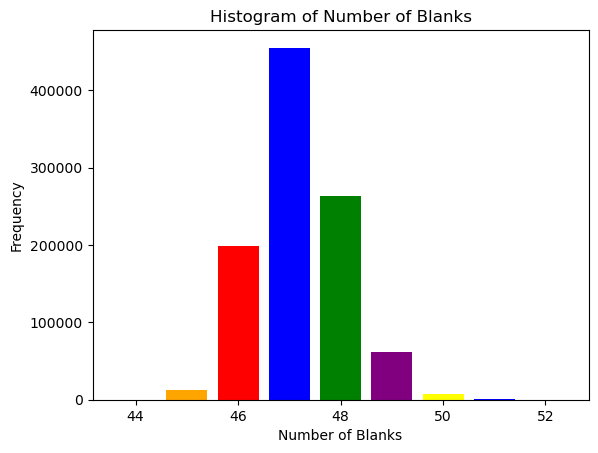

In [15]:
plt.bar(value_counts.index, value_counts.values, color=['blue', 'green', 'red', 'purple', 'orange', 'yellow'])

plt.xlabel('Number of Blanks')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Blanks')

plt.show()

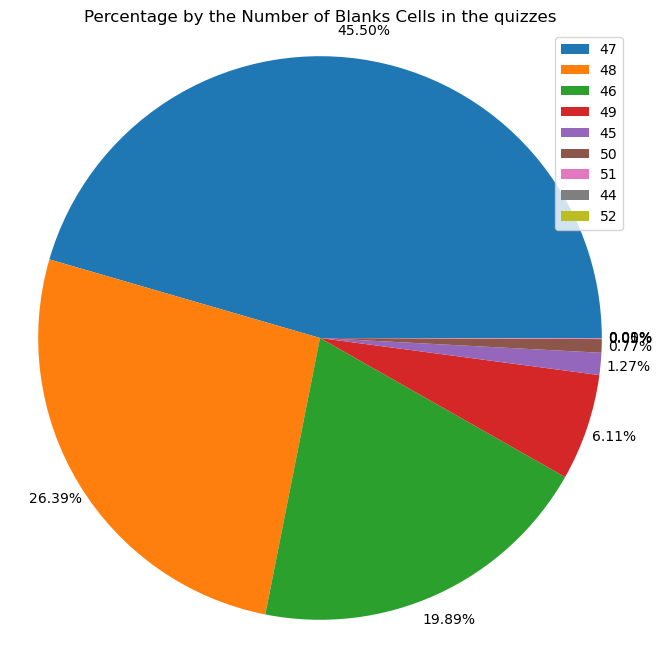

In [16]:
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(data['number_blanks'].value_counts(), autopct='%1.2f%%', pctdistance=1.1)
ax1.legend(data['number_blanks'].value_counts().index)
ax1.axis('equal')

plt.title("Percentage by the Number of Blanks Cells in the quizzes")
plt.show()

### Print an example

In [22]:
print("Quiz:\n",np.array(list(map(int,list(data['quizzes'][0])))).reshape(9,9))
print("Solution:\n",np.array(list(map(int,list(data['solutions'][0])))).reshape(9,9))

Quiz:
 [[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]]
Solution:
 [[8 6 4 3 7 1 2 5 9]
 [3 2 5 8 4 9 7 6 1]
 [9 7 1 2 6 5 8 4 3]
 [4 3 6 1 9 2 5 8 7]
 [1 9 8 6 5 7 4 3 2]
 [2 5 7 4 8 3 9 1 6]
 [6 8 9 7 3 4 1 2 5]
 [7 1 3 5 2 8 6 9 4]
 [5 4 2 9 1 6 3 7 8]]


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=64, subset="train", shuffle=False, info={}):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.subset = subset
        self.info = info
        
        self.data_path = resources_path
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))  # Use np.ceil to include the remaining samples in the last batch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        X = np.empty((self.batch_size, 9, 9, 1))
        y = np.empty((self.batch_size, 81, 1))
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        for i, f in enumerate(self.df['quizzes'].iloc[indexes]):
            self.info[index * self.batch_size + i] = f
            X[i,] = (np.array(list(map(int, list(f)))).reshape((9, 9, 1)) / 9) - 0.5
        if self.subset == 'train':
            for i, f in enumerate(self.df['solutions'].iloc[indexes]):
                self.info[index * self.batch_size + i] = f
                y[i,] = np.array(list(map(int, list(f)))).reshape((81, 1)) - 1
        if self.subset == 'train':
            return X, y
        else:
            return X

In [ ]:
model = create_model1()
model2 = create_model2()
model3 = create_model3()
model4 = create_model4()

# model = tf.keras.models.load_model('/home/djunice/EnigmaGridSolver/Sudoku.NeuralNet/Resources/tf4-0.h5')

In [ ]:
model.summary()

### Data Generators
We will be creating training and test data generator. Lets use 95% data for training and 5% data for validation as 5% of 9Million is still very large for validation purposes. 

In [ ]:
train_idx = int(len(data)*0.95)
data = data.sample(frac=1).reset_index(drop=True)
training_generator = DataGenerator(data.iloc[:train_idx], subset = "train", batch_size=64)
validation_generator = DataGenerator(data.iloc[train_idx:], subset = "train",  batch_size=64)

In [ ]:
training_generator.__getitem__(4)[0].shape

### Callbacks

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(training_generator, validation_data = validation_generator, batch_size = 64, epochs = 10, verbose=1, callbacks=[reduce_lr])

In [ ]:
# save model and architecture to single file
model.save("cnn4-1.keras")

## <span style="color:teal;text-decoration:underline">Solving Real Sudokus</span>

In [ ]:
def solve_sudoku_with_nn(model, puzzle):
    # Preprocess the input Sudoku puzzle
    puzzle = puzzle.replace('\n', '').replace(' ', '')
    initial_board = np.array([int(j) for j in puzzle]).reshape((9, 9, 1))
    initial_board = (initial_board / 9) - 0.5

    while True:
        # Use the neural network to predict values for empty cells
        predictions = model.predict(initial_board.reshape((1, 9, 9, 1))).squeeze()
        pred = np.argmax(predictions, axis=1).reshape((9, 9)) + 1
        prob = np.around(np.max(predictions, axis=1).reshape((9, 9)), 2)

        initial_board = ((initial_board + 0.5) * 9).reshape((9, 9))
        mask = (initial_board == 0)

        if mask.sum() == 0:
            # Puzzle is solved
            break

        prob_new = prob * mask

        ind = np.argmax(prob_new)
        x, y = (ind // 9), (ind % 9)

        val = pred[x][y]
        initial_board[x][y] = val
        initial_board = (initial_board / 9) - 0.5

    # Convert the solved puzzle back to a string representation
    solved_puzzle = ''.join(map(str, initial_board.flatten().astype(int)))

    return solved_puzzle

You can put in any game in the "game" string to solve it. Just copy new_game string in the game string and modify the desired zeros.

In [ ]:
def print_sudoku_grid(puzzle):
    puzzle = puzzle.replace('\n', '').replace(' ', '')
    for i in range(9):
        if i % 3 == 0 and i != 0:
            print("-"*21)

        for j in range(9):
            if j % 3 == 0 and j != 0:
                print("|", end=" ")
            print(puzzle[i*9 + j], end=" ")
        print()
new_game = '''
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
          0 0 0 0 0 0 0 0 0
      '''

game = '''
          0 0 0 7 0 0 0 9 6
          0 0 3 0 6 9 1 7 8
          0 0 7 2 0 0 5 0 0
          0 7 5 0 0 0 0 0 0
          9 0 1 0 0 0 3 0 0
          0 0 0 0 0 0 0 0 0
          0 0 9 0 0 0 0 0 1
          3 1 8 0 2 0 4 0 7
          2 4 0 0 0 5 0 0 0
      '''

solved_puzzle_nn = solve_sudoku_with_nn(model, game)

# Print the solved puzzle as a grid
print("Sudoku Solution (NN):")
print_sudoku_grid(solved_puzzle_nn)